In [3]:
import os
import webbrowser
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geocoder
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import sklearn
from sklearn.cluster import KMeans
import folium
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
import time
from fuzzywuzzy import fuzz

print("Libraries Imported")


Libraries Imported


C:\Users\dilip.sah\AppData\Local\Continuum\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# This Capstone project has been created to satisfy the needs of IBM Data Science project.
# Finding Best Neighbourhood to Fight Covid-19 in New York City

In [4]:
def get_new_york_data():
    """
    This method is to collect New York City data with Borough, Neighborhood, Latitude and Longitude. 
    Will return a pandas dataframe
    """
    NY_DATASET = "https://cocl.us/new_york_dataset"
    resp = requests.get(NY_DATASET).json()
    features = resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
    new_york_data = pd.DataFrame(columns=column_names)

    for data in features:
        borough = data['properties']['borough']
        neighborhood_name = data['properties']['name']

        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]

        new_york_data = new_york_data.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)

    return new_york_data

In [5]:
ny_df = get_new_york_data()

In [6]:
ny_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
def get_population_per_neighbourhood(read_from_csv=False):
    """
    It will first fetch the borugh and neighborhood table from wikipedia. Then go to each     link of the neighborhoods in the table. Finally, it will create a dataframe cotaining     Borough, Neighborhood and Population. It has a functionality to store the data in csv     format, and it is possible to read this data from csv to reduce time consuming            operations later.
    """
    if not read_from_csv:
        WIKI_LINK = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City"
        ROOT_WIKI_LINK = "https://en.wikipedia.org"
        page = requests.get(WIKI_LINK)
        soup = BeautifulSoup(page.text, 'html.parser')
        population_list = []
        for table_row in soup.select("table.wikitable tr"):
            cells = table_row.findAll('td')
            if len(cells) > 0:
                borough = cells[0].text.strip().replace(
                    '\xa0', ' ').split(' ')[0]
                population = int(cells[3].text.strip().replace(',', ''))
                print('Getting data for borough: ',borough)
                for item in cells[4].findAll('a'):
                    neighborhood = item.text
                    neighbourhood_page = requests.get(
                        ROOT_WIKI_LINK+item['href'])
                    soup = BeautifulSoup(
                        neighbourhood_page.text, 'html.parser')
                    table = soup.select("table.infobox tr")
                    should_record = False
                    for row in table:
                        head = row.find('th')
                        body = row.find('td')
                        if head and 'population' in head.text.lower():
                            should_record = True
                            continue
                        if should_record:
                            try:
                                population_list.append(
                                    [borough, neighborhood, int(body.text.replace(',', ''))])
                            except:
                                pass
                            should_record = False
        df = pd.DataFrame(population_list, columns=[
                          "Borough", "Neighborhood", "Population"])
        df.to_csv('population.csv')
    else:
        df = pd.read_csv('population.csv')
    df = df.sort_values(by=['Borough'])
    df = df.drop_duplicates(subset='Neighborhood', keep='last')
    return df

In [8]:
nyc_population_df = get_population_per_neighbourhood()

In [10]:
nyc_population_df.head()

,Borough,Neighborhood,Population
0,Bronx,Melrose,24913
25,Bronx,Bruckner,38557
26,Bronx,Castle Hill,38557
27,Bronx,Clason Point,9136
28,Bronx,Harding Park,9136


In [12]:
# Combine NYC Geo data with Population data
ny_df.set_index('Neighborhood')
nyc_population_df.set_index('Neighborhood')
nyc_df = pd.merge(ny_df, nyc_population_df, how="inner", on=["Borough", "Neighborhood"])
nyc_df.head()

,Borough,Neighborhood,Latitude,Longitude,Population
0,Bronx,Wakefield,40.894705,-73.847201,29158
1,Bronx,Co-op City,40.874294,-73.829939,43752
2,Bronx,Fieldston,40.895437,-73.905643,3292
3,Bronx,Riverdale,40.890834,-73.912585,48049
4,Bronx,Kingsbridge,40.881687,-73.902818,10669


In [13]:
# Let us see some bar charts of this data
def show_bar_chart(df, group, field, title, x_label, y_label, calculation="sum"):
    """
    A generic function to render bar charts
    """
    plt.figure(figsize=(9, 5), dpi=100)
    plt.title(title)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    if calculation == "sum":
        df.groupby(group)[field].sum().plot(kind='bar')
    if calculation == "count":
        df.groupby(group)[field].count().plot(kind='bar')
    plt.legend()
    plt.show()

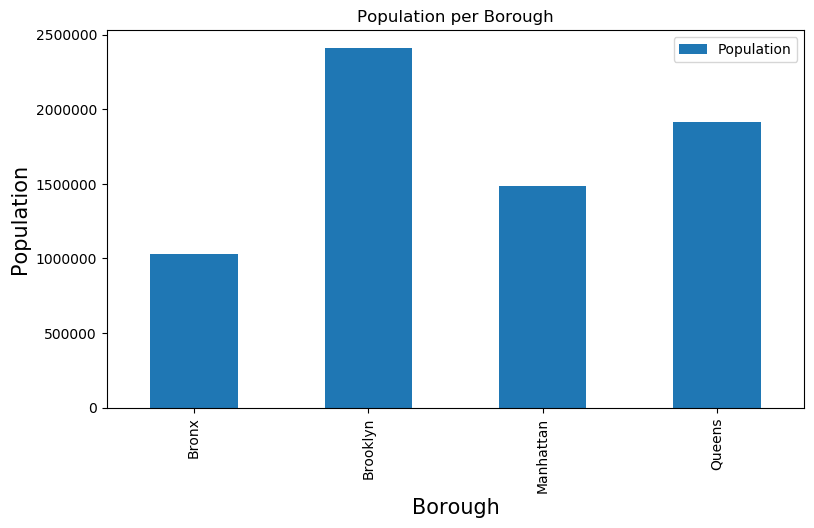

In [14]:
show_bar_chart(nyc_df, group="Borough", field="Population", title="Population per Borough",  x_label="Borough", y_label="Population")

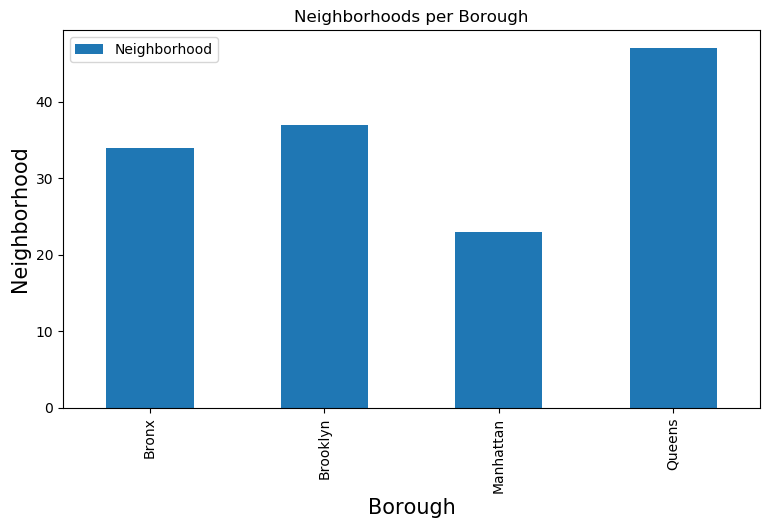

In [15]:
show_bar_chart(nyc_df, group="Borough", field="Neighborhood", title="Neighborhoods per Borough",  x_label="Borough", y_label="Neighborhood", calculation="count")

In [16]:
# Now, let us fetch hospital information for each Neighborhood
def get_hospital_data(lat, lng, borough, neighborhood):
    """
    We are going to utilize foursquare API to fetch hospital data. It will take latitude,     longitude and return hospital information.
    """
    radius = 1000
    LIMIT = 100
    VERSION = '20200328'
    FS_CLIENT_ID = "WU2UX203XESJA0HFY55SV5RWZ1BBSKLI32QJYVRJSYA5LFBP"
    FS_CLIENT_SECRET = "CRCZYN4G5KWRGZPK3BV4ELWGXR1BOY05S1S3U2RGZCMTTCOA"
    FS_HOSPITAL_KEY = "4bf58dd8d48988d196941735"
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        FS_CLIENT_ID,
        FS_CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT,
        FS_HOSPITAL_KEY)
    response = requests.get(url)
    if not response.status_code == 200:
        print("ERROR", response.status_code, response.content)
        return None
    results = response.json()
    venue_data = results["response"]["venues"]
    venue_details = []
    for row in venue_data:
        try:
            venue_id = row['id']
            venue_name = row['name']
            lat = row["location"]["lat"]
            lng = row["location"]["lng"]
            venue_details.append(
                [venue_id, venue_name, lat, lng, borough, neighborhood])
        except KeyError:
            pass

    column_names = ['ID', 'Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    df = pd.DataFrame(venue_details, columns=column_names)
    return df

In [24]:
# Let us also write another function to utilize the nyc_df to get hospital data
def get_hospital_per_neighborhood_borough(df):
    """
    It will utilize NYC_DF and get hospital per neighborhood.
    """
    column_names = ['ID', 'Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    data = []
    for i, row in df.iterrows():
        print (f"Getting hospital data for borough:{row['Borough']} and neighbourhood : {row['Neighborhood']}")
        h_df = get_hospital_data(
            row["Latitude"], row["Longitude"], row["Borough"], row["Neighborhood"])
        if h_df is not None:
            for x, hrow in h_df.iterrows():
                data.append([hrow[column] for column in column_names])

    n_df = pd.DataFrame(data, columns=column_names)
    n_df.to_csv('hospital_per_boro_nei.csv')
    return n_df

In [25]:
# Now let us use the above function
hospital_df = get_hospital_per_neighborhood_borough(nyc_df)
hospital_df.head()

Getting hospital data for borough:Bronx and neighbourhood : Wakefield
Getting hospital data for borough:Bronx and neighbourhood : Co-op City
Getting hospital data for borough:Bronx and neighbourhood : Fieldston
Getting hospital data for borough:Bronx and neighbourhood : Riverdale
Getting hospital data for borough:Bronx and neighbourhood : Kingsbridge
Getting hospital data for borough:Bronx and neighbourhood : Woodlawn
Getting hospital data for borough:Bronx and neighbourhood : Norwood
Getting hospital data for borough:Bronx and neighbourhood : Williamsbridge
Getting hospital data for borough:Bronx and neighbourhood : Baychester
Getting hospital data for borough:Bronx and neighbourhood : Pelham Parkway
Getting hospital data for borough:Bronx and neighbourhood : Bedford Park
Getting hospital data for borough:Bronx and neighbourhood : University Heights
Getting hospital data for borough:Bronx and neighbourhood : Morris Heights
Getting hospital data for borough:Bronx and neighbourhood : Fo

,ID,Name,Latitude,Longitude,Borough,Neighborhood
0,59832a7bfe37406ea7eb3a79,Statcare Urgent & Walk-In Medical Care (Bronx ...,40.870168,-73.828404,Bronx,Co-op City
1,50173409e4b0cfe38c43abf4,wellcare,40.874247,-73.837745,Bronx,Co-op City
2,568e86f5498ec6df53771448,CityMD Baychester Urgent Care - Bronx,40.866795,-73.827051,Bronx,Co-op City
3,5158ddffe4b086af71ca90c7,The Mollie & Jack Zicklin Jewish Hospice Resid...,40.888478,-73.910047,Bronx,Fieldston
4,5158ddffe4b086af71ca90c7,The Mollie & Jack Zicklin Jewish Hospice Resid...,40.888478,-73.910047,Bronx,Riverdale


In [37]:
NYM_NYC = [
        103016, 106804, 102908, 103035, 102934, 1256608, 105117, 103009, 102974, 103006, 103041, 105086, 103056, 103086, 102973,
        102970, 102950, 103074, 103008, 103007, 102985, 103012, 106809, 102937, 103068, 102944, 102995, 106803, 102916, 105109,
        102914, 102960, 103038, 106810, 106811, 102961, 102940, 102933, 103078, 254693, 103065, 103021, 103080, 103033, 102919,
        105116, 106825, 103084, 103087, 102989, 102929, 106817, 106819, 103073, 103085, 103025
    ]  # New York Metro: New York City Hospitals' IDs 
NYM_LI = [
        102999, 103062, 102928, 103002, 102980, 103077, 103049, 103011, 102918, 102965, 102994, 102966, 103069, 1189331, 102926,
        103088, 103045, 103000, 103070, 105137, 103082, 102954, 103072
    ] # New York Metro: Long Iceland Hospitals' IDs
BRONX = [
        102908, 106804, 105117, 102973, 102950, 106809, 102937, 103068, 102944, 103078, 103087
    ] # New York Metro: Bronx Hospitals' IDs
QUEENS = [
        102974, 103006, 102912, 103074, 103008, 105109, 102933, 103033, 103084
    ] # New York Metro: Queens Hospitals' IDs

HOSPITALS = list(set(NYM_LI + NYM_NYC + BRONX + QUEENS))
print('Total hospitals', len(HOSPITALS))

Total hospitals 80


# Get hospital data usig Selenium driver for Chrome.

In [38]:
from selenium.webdriver import Chrome


In [43]:
# Now let us fetch hospital bed data from NYS Health Profile
def get_bed_per_hospital():
    """
    We are going to fetch data NYS Health Profile. A selenium based scrapper will be used     as it is a dynamic site. A fixed list of IDs have been used for fetching data. These      IDs are collected manualy from the website. They represent the NYC hospitals.
    """
    ROOT_URL = "https://profiles.health.ny.gov/hospital/printview/{}"

    hospital_data = []

    for val in HOSPITALS:
        print("Processing hospital id", val)
        url = ROOT_URL.format(val)

        try:
            browser = Chrome()
            browser.get(url)
            time.sleep(10)
            html = browser.page_source
            soup = BeautifulSoup(html, 'html.parser')
            hospital_name = soup.find('h2').text.strip()
            table = soup.select("table", id="number-of-beds")[0]
            rows = table.findAll('tr')
            
            icu_beds = 0
            for row in rows:
                tds = row.findAll('td')
                should_record = False
                for td in tds:
                    if "intensive care beds" == td.text.lower():
                        should_record = True
                        continue
                    if should_record:
                        icu_beds = td.text

            bed_number = rows[-1].findAll('td')[-1].text
            print(hospital_name, bed_number, icu_beds)
            hospital_data.append([hospital_name, bed_number, icu_beds])
        except Exception as e:
            print(e)
        browser.quit()
    df = pd.DataFrame(
        hospital_data, columns=[
            "Hospital Name", "Bed Number", "ICU Bed Number"
        ]
    )
    df = df.drop_duplicates(subset='Hospital Name', keep='last')
    df.to_csv('hospital_beds.csv')
    return df

In [44]:
# Let us get the hospital bed data
hospital_bed_df = get_bed_per_hospital()
hospital_bed_df.head()

Processing hospital id 102912
Jamaica Hospital Medical Center 402 8
Processing hospital id 102914
New York Community Hospital of Brooklyn, Inc 134 7
Processing hospital id 102916
Mount Sinai Hospital 1139 85
Processing hospital id 102918
Nassau University Medical Center 530 22
Processing hospital id 102919
Richmond University Medical Center 448 20
Processing hospital id 102926
Southside Hospital 305 26
Processing hospital id 102928
Huntington Hospital 348 12
Processing hospital id 102929
Mount Sinai Morningside 495 24
Processing hospital id 102933
New York-Presbyterian/Queens 535 29
Processing hospital id 102934
Brooklyn Hospital Center - Downtown Campus 464 24
Processing hospital id 102937
Montefiore Medical Center - Henry & Lucy Moses Div 816 48
Processing hospital id 102940
New York-Presbyterian/Lower Manhattan Hospital 180 13
Processing hospital id 102944
Montefiore Medical Center-Wakefield Hospital 321 16
Processing hospital id 102950
Lincoln Medical & Mental Health Center 362 23


,Hospital Name,Bed Number,ICU Bed Number
0,Jamaica Hospital Medical Center,402,8
1,"New York Community Hospital of Brooklyn, Inc",134,7
2,Mount Sinai Hospital,1139,85
3,Nassau University Medical Center,530,22
4,Richmond University Medical Center,448,20


In [45]:
# Now let us combine hospital ber neighborhood data with hospital bed data
def combine_hospital_beds_with_boro_neighborhood(hospital_df, hospital_boro_nei_df):
    # Uses fuzzywuzzy to match hospital name from Foursquare to NYS
    data = []
    column_names = ["Hospital Name", "Bed Number", "ICU Bed Number"]
    boro_neig_column_names = ["Borough", "Neighborhood"]
    for i, row in hospital_df.iterrows():
        data_per_hospital = None
        max_ratio = 0
        for x, hrow in hospital_boro_nei_df.iterrows():
            ratio = fuzz.token_sort_ratio(row["Hospital Name"], hrow["Name"])
            if ratio > max_ratio:
                max_ratio = ratio
                data_per_hospital = [
                    row[column] for column in column_names] + \
                    [hrow[column] for column in boro_neig_column_names
                     ]
        if data_per_hospital:
            data.append(data_per_hospital)

    df = pd.DataFrame(data, columns=column_names+boro_neig_column_names)
    df.to_csv('cleaned_hospital_data.csv')
    return df


In [46]:
h_df = combine_hospital_beds_with_boro_neighborhood(hospital_bed_df, hospital_df)
h_df.head()

,Hospital Name,Bed Number,ICU Bed Number,Borough,Neighborhood
0,Jamaica Hospital Medical Center,402,8,Queens,Briarwood
1,"New York Community Hospital of Brooklyn, Inc",134,7,Brooklyn,Fort Greene
2,Mount Sinai Hospital,1139,85,Manhattan,Yorkville
3,Nassau University Medical Center,530,22,Bronx,University Heights
4,Richmond University Medical Center,448,20,Bronx,University Heights


In [47]:
# Now let us clean up the hospital. We will combine total bed count and icu bed count per borough and neighbourhood
h_df.dtypes
h_df = h_df.astype({'Bed Number': 'int32', 'ICU Bed Number': 'int32'})

In [48]:
# Let us clean up the data by combining total bed count and icu bed count per neighborhood and borough
h_df = h_df.groupby(
    ["Neighborhood", "Borough"]
).agg(
    {
        "Bed Number": "sum",
        "ICU Bed Number": "sum"
    }
)
h_df.head()


,,Bed Number,ICU Bed Number
Neighborhood,Borough,,
Bensonhurst,Brooklyn,204,8
Borough Park,Brooklyn,711,40
Briarwood,Queens,671,24
Brighton Beach,Brooklyn,306,17
Brownsville,Brooklyn,600,28


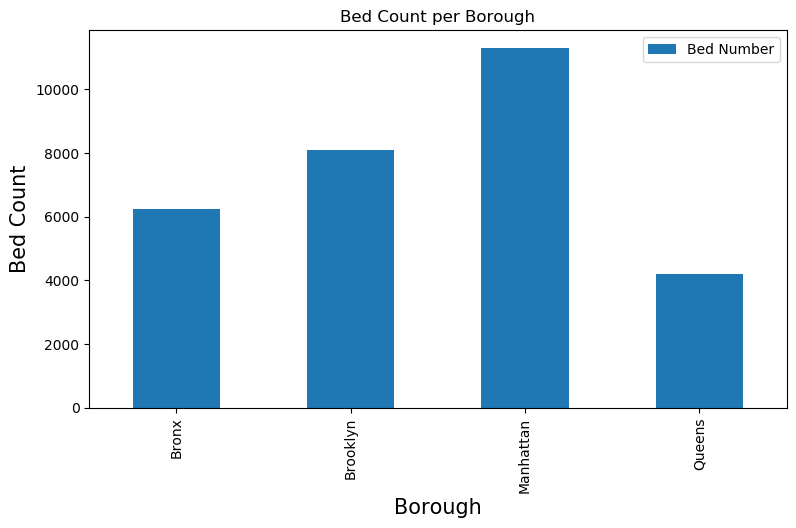

In [49]:
# Cool. Now let us see how this data looks in bar chart
show_bar_chart(h_df, group="Borough", field="Bed Number", title="Bed Count per Borough",  x_label="Borough", y_label="Bed Count", calculation="sum")

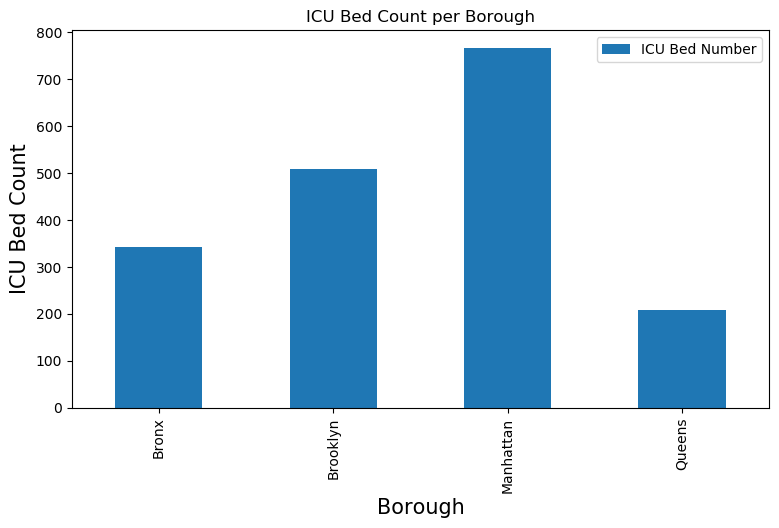

In [50]:
show_bar_chart(h_df, group="Borough", field="ICU Bed Number", title="ICU Bed Count per Borough",  x_label="Borough", y_label="ICU Bed Count", calculation="sum")

In [51]:
# We can see that Manhattan has most hospital beds
# Now let us combine the nyc_data with h_data
df = pd.merge(h_df, nyc_df, how="inner", on=["Borough", "Neighborhood"])
df.head()

,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population
0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705
1,Brooklyn,Borough Park,711,40,40.633131,-73.990498,106357
2,Queens,Briarwood,671,24,40.710935,-73.811748,53877
3,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547
4,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300


In [52]:
# We will add bed per 100 people data with the dataframe
def get_bed_per_hunderd_person(row, field="Bed Number"):
    """
    Will return bed per hundered data. field can be beds or icu beds
    """
    return row[field] * 100 / row["Population"]

df["ICU Bed Per Hundred People"] = df.apply(
    lambda row: get_bed_per_hunderd_person(row, field="ICU Bed Number"), axis=1)

df["Bed Per Hundred People"] = df.apply(
    lambda row: get_bed_per_hunderd_person(row), axis=1)

df.head()

,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People
0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705,0.005273,0.134472
1,Brooklyn,Borough Park,711,40,40.633131,-73.990498,106357,0.037609,0.668503
2,Queens,Briarwood,671,24,40.710935,-73.811748,53877,0.044546,1.245429
3,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547,0.047824,0.860832
4,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300,0.048027,1.029160


In [53]:
# Cleaning data for k-means
df_clusters = df.drop(['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'ICU Bed Number', 'Bed Number'],axis = 1)

#  Kmeans will be used for feature set ICU Beds and Beds Per 100 people.
#  Optimum number for k will be calculated using Elbow method.

In [54]:
# Now we are going to use k-means clustering to partition data in k partitions
# We are going to use elbow method to find the optimum number of cluster

def plot_kmeans(dataset):
    obs = dataset.copy()
    silhouette_score_values = list()
    number_of_clusters = range(3, 30)
    for i in number_of_clusters:
        classifier = KMeans(i, init='k-means++', n_init=10,
                            max_iter=300, tol=0.0001, random_state=10)
        classifier.fit(obs)
        labels = classifier.predict(obs)
        silhouette_score_values.append(sklearn.metrics.silhouette_score(
            obs, labels, metric='euclidean', random_state=0))

    plt.plot(number_of_clusters, silhouette_score_values)
    plt.title("Silhouette score values vs Numbers of Clusters ")
    plt.show()

    optimum_number_of_components = number_of_clusters[silhouette_score_values.index(
        max(silhouette_score_values))]
    print("Optimal number of components is:")
    print(optimum_number_of_components)


In [55]:
# Normalizing data
df_clusters = sklearn.preprocessing.StandardScaler().fit_transform(df_clusters)
df_clusters

array([[ 2.31191653e+00, -4.15663386e-01, -5.71116631e-01],
       [ 1.16829711e+00, -3.09843551e-01, -4.06252832e-01],
       [-1.55182370e-01, -2.87142910e-01, -2.28146869e-01],
       [-6.17441875e-01, -2.76415239e-01, -3.46877951e-01],
       [-4.36398833e-02, -2.75749487e-01, -2.94912703e-01],
       [ 1.74535232e+00, -3.92406266e-01, -5.35235630e-01],
       [-1.18975596e+00,  3.05454430e-01,  6.72382906e-01],
       [-3.07327029e-01, -3.44000719e-01, -4.96484319e-01],
       [-3.56755759e-01, -3.47334556e-01, -4.13476216e-01],
       [ 2.09238740e+00, -4.03170450e-01, -5.50671095e-01],
       [ 1.40948914e+00, -7.43909817e-02, -3.09974415e-02],
       [-4.18819079e-01, -3.27411164e-01, -4.12142451e-01],
       [ 8.36390976e-02, -1.79784896e-01,  1.89627651e-02],
       [ 1.90624788e+00, -3.46051575e-01, -4.78098182e-01],
       [ 1.14630636e-04, -3.89312429e-01, -4.80474064e-01],
       [-4.19550422e-01,  9.49796144e-02,  1.19425305e-01],
       [ 5.97622238e-01, -3.23482027e-01

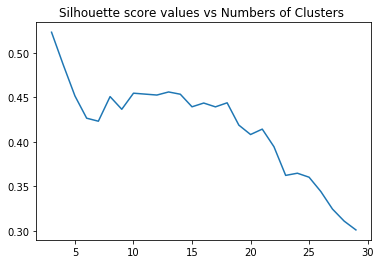

Optimal number of components is:
3


In [56]:
# Performing k-means clustering
plot_kmeans(df_clusters)

In [59]:
# We get the optimum number of k is 3
kclusters = 3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:24]

array([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1])

In [74]:
# Combining cluster data with dataframe
#df.insert(0, 'Cluster Labels', kmeans.labels_)
df.head()

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People
0,0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705,0.005273,0.134472
1,0,Brooklyn,Borough Park,711,40,40.633131,-73.990498,106357,0.037609,0.668503
2,1,Queens,Briarwood,671,24,40.710935,-73.811748,53877,0.044546,1.245429
3,1,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547,0.047824,0.860832
4,1,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300,0.048027,1.029160


In [105]:
# Now, it is time to create maps representing our clusters. The first map is illustrating the clusters where the radius of the Circle marker is proportional to Bed Countof 100 people in each borough.


In [61]:
def get_geo_location(address):
    """
    This function will return lattitude and longitude of an given address
    """
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location:
        latitude = location.latitude
        longitude = location.longitude
        return [latitude, longitude]
    return [None, None]

In [62]:
def save_map(m, filepath='map.html'):
    m.save(filepath)

def render_map_clusters(df, df_clusters, bpp_df=df_clusters[:, 1],kclusters=3, m_boost=5, add_boost=5):
    """
    This function will render map for dataframe using folium
    """
    map_clusters = folium.Map(
        location=get_geo_location("New York"), zoom_start=11)
    colours = ['red', 'black', 'blue']
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    markers_colors = []
    for lat, lon, poi, nei, cluster, bed_per_people in zip(df['Latitude'], df['Longitude'], df['Borough'], df["Neighborhood"], df['Cluster Labels'], bpp_df):
        label = folium.Popup(
            ' Cluster ' + str(cluster)+': ' + str(poi) + "-" + str(nei),
            parse_html=True
        )
        folium.CircleMarker(
            [lat, lon],
            radius=bed_per_people*m_boost+add_boost,
            popup=label,
            color=colours[cluster],
            fill=True,
            fill_color=colours[cluster],
            fill_opacity=0.7).add_to(map_clusters)
    return map_clusters

In [63]:
# Now let us render the map
map_clusters = render_map_clusters(df, df_clusters)
map_clusters
save_map(map_clusters)


In [64]:
# Now let us render the map for bed per 100 people
map_clusters = render_map_clusters(df, df_clusters,df['Bed Per Hundred People'],m_boost=1,add_boost=5)
map_clusters
save_map(map_clusters, 'bed_per_hundred.html')

In [65]:
# Now let us render the map for ICU bed per 100 people
map_clusters = render_map_clusters(df, df_clusters,df['ICU Bed Per Hundred People'],m_boost=2,add_boost=5)
map_clusters
save_map(map_clusters, 'icu_bed_per_hundred.html')

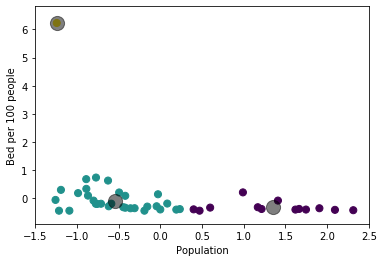

In [66]:
# Now we are going to use scatter plot

y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel('Population')
plt.ylabel('Bed per 100 people')
plt.show()

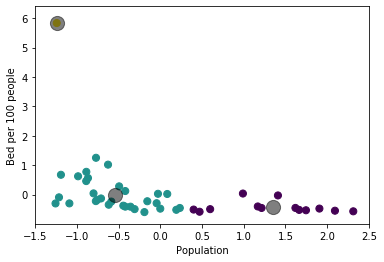

In [67]:
# Scatter plot for ICU bed per person

y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 2], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5);
plt.xlabel('Population')
plt.ylabel('Bed per 100 people')
plt.show()

In [68]:
# One outlier here is manhattun
# Now let us check the df per cluster
df[(df['Cluster Labels'] == 0)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People
0,0,Brooklyn,Bensonhurst,204,8,40.611009,-73.995180,151705,0.005273,0.134472
1,0,Brooklyn,Borough Park,711,40,40.633131,-73.990498,106357,0.037609,0.668503
5,0,Brooklyn,Bushwick,324,16,40.698116,-73.925258,129239,0.012380,0.250698
9,0,Brooklyn,Crown Heights,287,13,40.670829,-73.943291,143000,0.009091,0.200699
10,0,Manhattan,East Harlem,2184,127,40.792249,-73.944182,115921,0.109557,1.884042
13,0,Brooklyn,Erasmus,591,36,40.646926,-73.948177,135619,0.026545,0.435780
16,0,Queens,Forest Hills,312,28,40.725264,-73.844475,83728,0.033442,0.372635
21,0,Queens,Jackson Heights,545,20,40.751981,-73.882821,108152,0.018492,0.503920
31,0,Brooklyn,Prospect Lefferts Gardens,2080,197,40.658420,-73.954899,99287,0.198415,2.094937
34,0,Queens,South Ozone Park,247,11,40.668550,-73.809865,75878,0.014497,0.325523


In [69]:
df[(df['Cluster Labels'] == 1)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People
2,1,Queens,Briarwood,671,24,40.710935,-73.811748,53877,0.044546,1.245429
3,1,Brooklyn,Brighton Beach,306,17,40.576825,-73.965094,35547,0.047824,0.860832
4,1,Brooklyn,Brownsville,600,28,40.663950,-73.910235,58300,0.048027,1.029160
6,1,Brooklyn,Carroll Gardens,535,29,40.680540,-73.994654,12853,0.225628,4.162452
7,1,Manhattan,Chinatown,180,13,40.715618,-73.994279,47844,0.027172,0.376223
8,1,Manhattan,Clinton,296,12,40.759101,-73.996119,45884,0.026153,0.645105
11,1,Bronx,East Tremont,282,14,40.842696,-73.887356,43423,0.032241,0.649425
12,1,Manhattan,East Village,1296,49,40.727847,-73.982226,63347,0.077352,2.045874
14,1,Queens,Far Rockaway,257,8,40.603134,-73.754980,60035,0.013326,0.428084
15,1,Bronx,Fordham,1029,70,40.860997,-73.896427,43394,0.161313,2.371296


In [70]:
df[(df['Cluster Labels'] == 2)]

,Cluster Labels,Borough,Neighborhood,Bed Number,ICU Bed Number,Latitude,Longitude,Population,ICU Bed Per Hundred People,Bed Per Hundred People
26,2,Manhattan,Murray Hill,2270,221,40.748303,-73.978332,10864,2.034242,20.894698


In [71]:
# Let us see neighborhoods which does not have any hospitals
excluded_df = pd.merge(nyc_df, df, how='outer', indicator=True, on=["Borough", "Neighborhood"])
excluded_df = excluded_df.loc[excluded_df._merge == 'left_only', ["Borough", "Neighborhood"]]
excluded_df.head(10)

,Borough,Neighborhood
0,Bronx,Wakefield
1,Bronx,Co-op City
2,Bronx,Fieldston
3,Bronx,Riverdale
4,Bronx,Kingsbridge
7,Bronx,Williamsbridge
8,Bronx,Baychester
10,Bronx,Bedford Park
15,Bronx,West Farms
17,Bronx,Mott Haven


In [72]:
# Let us see the length of df with/without hospital information
print("Neighborhood without hospital count:", len(excluded_df.index))
print("Neighborhood with hospital count:", len(df.index))

Neighborhood without hospital count: 97
Neighborhood with hospital count: 44


# Full report can be found in the doc file and presentation is also available in Git Hub repository